## Variational Autoencoders (VAE)

Our goal for using generative models, is to be able to generate a rich latent space, where we can start to make primitive algebraic operations. This has been shown to be the case in the computer vision world, using [conditional GANs](https://arxiv.org/pdf/1411.1784.pdf), and is similar to the results for word embeddings. It is our goal to explore these models, for example, doing the [DCGAN Faces tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) from the pytorch blog. 

#### Visualization of interpolation in latent space

In [2]:
from IPython.display import Image

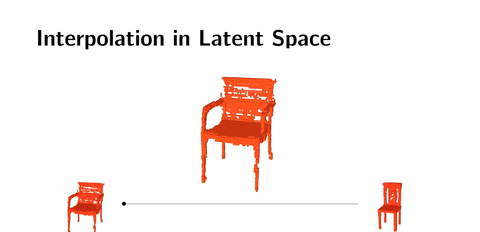

In [3]:
with open('inter_latent.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

More interestingly, we would like to know why such algebraic operations in the latent space representations, in which cases they work well and in which cases they don't; which architectures give the best latent spaces for certain classes of data and so forth. Another interesting thing is to explore what lies beyond the scope of the latent space, i.e., what would happen if we extrapolate values outside of the ranges of the "seen" training data. 

An explanation is given by [this paper, about GANs' latent spaces ](http://proceedings.mlr.press/v80/bojanowski18a/bojanowski18a.pdf): 

> #### "The generator translates linear interpolations in the noise space into semantic interpolations in the image space... Linear arithmetic indicates that the generator organizes the noise space to disentangle the nonlinear factors of variation of natural images into linear statistics. "

Let's get started. 

### Constructing a VAE on pytorch. 

One interesting thing would be to use VAEs for modeling the CelebA dataset. But let's start off by building a VAE on the MNIST dataset. Once we get a handle for it, then we can extend to other datasets. 

In [4]:
import os
import numpy as np 
import tqdm 


import torch
import torch.nn as nn 
import torch.optim as optim 

import torchvision 
import torchvision.transforms as transforms 
import torch.nn.functional as F

In [5]:
seed = 42 

torch.manual_seed(seed)

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        #transforms.Normalize((0.5,), (0.5,))
    ]
)

In [7]:
trainset = torchvision.datasets.MNIST(
    root = './data/', 
    train = True, 
    download = True, 
    transform = transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size = 100, 
    shuffle = True, 
    num_workers = 2
)


testset = torchvision.datasets.MNIST(
    root = './data',
    train = False, 
    download = True, 
    transform = transform 
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size = 100, 
    shuffle = False, 
    num_workers = 2
)

In [8]:
classes =  (np.arange(10))

We will follow [this tutorial](https://chrisorm.github.io/VAE-pyt.html). The neat thing about it is that has a helper function to extract the latent space. 

In [9]:
2**8

256

In [10]:
from torch.autograd import Variable


In [11]:
%load_ext blackcellmagic

In [12]:
latent_dim = 10
input_size = 784
batch_size = 100

In [13]:
class VAE(nn.Module):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()

        # Encoder layers
        self.en1 = nn.Linear(input_size, 256)

        self.mu_ = nn.Linear(256, latent_dim)
        self.std_ = nn.Linear(256, latent_dim)

        # Decoder layers
        self.de1 = nn.Linear(latent_dim, 256)
        self.de2 = nn.Linear(256, input_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """
        Encode a batch of samples and return posterior parameters 
        mu_ and std_ for each point. 
        """

        h1 = self.relu(self.en1(x))

        return self.mu_(h1), self.std_(h1)

    def decode(self, z):
        """
        Decode a batch of latent variables. 
        """

        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))

    def reparam(self, mu, logvar):
        """
        Reparametrization trick to sample z values. 
        This is a stochastic procedure, and returns the mode
        during evaluation.
        
        """

        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())

            return eps.mul(std).add_(mu)

        else:
            mu

    def forward(self, x):
        """
        Takes a batch of samples, encodes them, and then decodes 
        them again for comparison. 
        """

        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)

        return self.decode(z), mu, logvar

    def loss(self, reconstruction, x, mu, logvar):

        """
        ELBO assuming entries of x are binary variables, or can be approximated by it.
        It uses closed form of KL divergence between two Gaussians. 
        """

        bce = torch.nn.functional.binary_cross_entropy(
            reconstruction, x.view(-1, input_size)
        )

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        #  Normalize by same number of elems as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD

    def get_z(self, x):
        """
        Encode a batch of data points into their latent representation z. 
        """

        mu, logvar = self.encode(x.view(-1, input_size))

        return self.reparam(mu, logvar)

In [14]:
model = VAE(**dict(input_size = input_size))

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [16]:
def init_network_weights(net): 
    """
    Initialize fully connected layers using the Xavier method. 
    """
    
    torch.manual_seed(42)
    
    for m in net.modules():
        torch.manual_seed(42)
        if isinstance(m, nn.Linear): 
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias)
            
    return net
    

In [17]:
model = init_network_weights(model)

In [18]:
for epoch in np.arange(8): 
    
    running_loss = 0
    
    for ix, data, in enumerate(tqdm.tqdm(trainloader)): 
        
        inputs, labels = data
        
        # Flatten batch before feeding, 
        # from a list of matrices, to
        # a list of vectors 
        
        input_ = inputs.view(batch_size, -1)
        
        # zero-out param gradients 
        optimizer.zero_grad()
        
        # Forward + backward + optimize 
        recon_batch, mu, logvar = model(input_)
        
        # Compute error 
        loss = model.loss(recon_batch, input_, mu, logvar)
        loss.backward() #backprop
        
        optimizer.step() # Update weights
        
        running_loss += loss.item()
        
        if ix % 200 == 199: # print every 200 mini-batches
            
            # Slightly awkward print statement 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, ix+1, running_loss / 200))
            
            # Reinitialize loss per minibatch 
            running_loss = 0.0
            
print('Finished training')

 34%|███▍      | 207/600 [00:03<00:07, 52.86it/s]

[1,   200] loss: 0.267


 68%|██████▊   | 406/600 [00:07<00:03, 50.05it/s]

[1,   400] loss: 0.189


  0%|          | 0/600 [00:00<?, ?it/s]

[1,   600] loss: 0.178


 35%|███▌      | 211/600 [00:03<00:06, 58.01it/s]

[2,   200] loss: 0.171


 69%|██████▊   | 412/600 [00:07<00:03, 59.24it/s]

[2,   400] loss: 0.168


  0%|          | 0/600 [00:00<?, ?it/s]

[2,   600] loss: 0.165


 35%|███▍      | 208/600 [00:03<00:06, 56.68it/s]

[3,   200] loss: 0.161


 68%|██████▊   | 410/600 [00:07<00:03, 58.21it/s]

[3,   400] loss: 0.160


  0%|          | 0/600 [00:00<?, ?it/s]

[3,   600] loss: 0.158


 34%|███▍      | 207/600 [00:03<00:07, 56.09it/s]

[4,   200] loss: 0.156


 68%|██████▊   | 409/600 [00:07<00:03, 56.11it/s]

[4,   400] loss: 0.155


  0%|          | 0/600 [00:00<?, ?it/s]

[4,   600] loss: 0.154


 35%|███▌      | 210/600 [00:03<00:07, 54.86it/s]

[5,   200] loss: 0.152


 68%|██████▊   | 406/600 [00:07<00:03, 58.00it/s]

[5,   400] loss: 0.152


  0%|          | 0/600 [00:00<?, ?it/s]

[5,   600] loss: 0.151


 35%|███▌      | 210/600 [00:04<00:08, 47.58it/s]

[6,   200] loss: 0.150


 68%|██████▊   | 406/600 [00:08<00:03, 48.82it/s]

[6,   400] loss: 0.150


  0%|          | 0/600 [00:00<?, ?it/s]

[6,   600] loss: 0.149


 34%|███▍      | 205/600 [00:04<00:08, 47.39it/s]

[7,   200] loss: 0.149


 68%|██████▊   | 408/600 [00:08<00:04, 46.17it/s]

[7,   400] loss: 0.148


  0%|          | 0/600 [00:00<?, ?it/s]

[7,   600] loss: 0.148


 35%|███▌      | 210/600 [00:04<00:07, 49.15it/s]

[8,   200] loss: 0.148


 68%|██████▊   | 407/600 [00:08<00:03, 49.88it/s]

[8,   400] loss: 0.147


100%|██████████| 600/600 [00:12<00:00, 46.60it/s]

[8,   600] loss: 0.146
Finished training


In [19]:
data = []
labels_ = []

for batch_x, label in tqdm.tqdm(testloader): 
    batch_x = batch_x.view(-1, 784)
    batch_x_preds = model.get_z(batch_x).detach().numpy()
    
    targets = label.detach().numpy()
    
    for x, y in zip(batch_x_preds, targets):
        
        #print('xshape: ', x.shape)
        data.append(x.reshape(latent_dim))
        
        labels_.append(y)

100%|██████████| 100/100 [00:01<00:00, 71.71it/s]


In [20]:
data_ = np.array(data)

In [21]:
from pandas import DataFrame

In [22]:
df = DataFrame(data_, columns = ['latent_' + str(i) for i in range(latent_dim)])

In [23]:
df.head()

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9
0,0.011412,-1.353068,0.258252,0.842071,2.247269,1.388452,-0.583039,0.844397,0.205891,1.235868
1,-0.401339,2.276679,-0.677913,-0.142092,-0.955959,-1.194784,0.492848,0.810666,1.517916,-1.358139
2,-0.086943,2.737158,0.153597,-1.598380,0.971886,-0.160086,0.656682,-0.255253,-0.958806,0.309871
3,-2.184509,-0.551139,-0.011211,2.554337,0.018215,-0.876460,0.001904,-0.222295,0.682885,0.447114
4,0.486942,-1.805259,-2.142680,-0.135087,1.131149,-1.501854,0.262493,-1.900867,-1.598037,-0.146141


In [24]:
df['labels'] = labels_

In [25]:
import hvplot.pandas

In [26]:
from colorcet import glasbey_cool as coolio

In [27]:
df.hvplot.scatter(
    x = 'latent_1', 
    y = 'latent_2', 
    c  = 'labels', 
    cmap = coolio[:10], 
    padding = 0.1, 
    alpha = 0.7, 
    width = 500
)

:Scatter   [latent_1]   (latent_2,labels)

In [28]:
from umap import UMAP 

In [29]:
latent_umap = UMAP(random_state = 42).fit_transform(data_)

/Users/manoloflores/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/manoloflores/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/utils.p

In [30]:
# Add umap coordinates to dataframe
df['u1'], df['u2'] = latent_umap.T

In [31]:
df.hvplot.scatter(
    x = 'u1', 
    y = 'u2', 
    c  = 'labels', 
    cmap = coolio[:10], 
    padding = 0.1, 
    alpha = 0.7, 
    width = 500
)

:Scatter   [u1]   (u2,labels)